In [1]:
import os
import numpy as np
import pandas as pd
from lumicks import pylake
from scipy.signal import find_peaks
from matplotlib import pyplot as plt

In [2]:
def get_scan_distance(marker, scan):
    """
    Get the distance data for a kymograph.

    :param marker: Pylake File object containing marker data.
    :param kymo: Kymograph object.
    :return: Upsampled distance data.
    """
    marker_time_ns = marker['Force LF']['Trap 1'].timestamps
    marker_distance = marker['Distance']['Distance 1'].data
    scan_start_time = min(scan.timestamps[:][0])
    scan_end_time = max(scan.timestamps[:][0])
    scan_time_ns = (marker_time_ns >= scan_start_time) & (marker_time_ns <= scan_end_time)
    scan_distance = np.mean(marker_distance[scan_time_ns])
    
    return scan_distance

def process_scan_h5(data_folder, scan_name, bead_size=4.35, start_pad=10):
    """
    Process kymographs to detect beads.

    :param data_folder: Path to the data folder.
    :param scan_name: scan.h5 file to process.
    :param bead_size: Size of the beads.
    :param start_pad: Padding at the start of the scan.
    """
    adjustment = pylake.ColorAdjustment([0], [10], mode="absolute", gamma=0.5)
    
    scan_file = pylake.File(os.path.join(data_folder, scan_name))
    scan_id = list(scan_file.scans.keys())[0]
    scan = scan_file.scans[scan_id]
    scan_img = scan.get_image()
    scan_pixel_size_um = scan.pixelsize_um[0]
    bead_window = int((bead_size /scan_pixel_size_um) * 1.15)

    bead_radius_pixels = (bead_size / scan_pixel_size_um) / 2
    scan_intensity = np.mean(scan_img[:, :, 1], axis=0)
    if start_pad > 0:
        scan_intensity = np.append(scan_intensity[-start_pad:], scan_intensity)

    rolling_mean = np.convolve(scan_intensity, np.ones(bead_window) / bead_window, mode='same')
    bead_peaks = find_peaks(rolling_mean, prominence=0, width=15, height=0, distance=100)
    peak_centres = bead_peaks[0]

    left_bead = peak_centres[0] - start_pad

    scan_distance = get_scan_distance(scan_file, scan)
    left_bead_start = (left_bead - bead_radius_pixels)
    left_bead_end = (left_bead + bead_radius_pixels)
    right_bead_start = left_bead_end + (scan_distance/scan_pixel_size_um)
    right_bead_end = left_bead_end + (scan_distance/scan_pixel_size_um) + (bead_radius_pixels * 2)

    left_bead_start_um = left_bead_start * scan_pixel_size_um
    left_bead_end_um = left_bead_end * scan_pixel_size_um
    right_bead_start_um = right_bead_start * scan_pixel_size_um
    right_bead_end_um = right_bead_end * scan_pixel_size_um

    plt.figure(figsize=(7, 10))
    scan.plot(adjustment=adjustment)
    #plt.hlines(left_bead_edges, 0, kymo.duration, color='yellow')

    plt.vlines([left_bead_start_um, left_bead_end_um], 0, scan.shape[0]* scan_pixel_size_um, color='yellow')
    plt.vlines([right_bead_start_um, right_bead_end_um], 0, scan.shape[0]* scan_pixel_size_um, color='yellow')

    plt.title(scan_name.removesuffix(".h5"))
    plt.show()

    bead_edges_df = {
        'Left_bead_start': left_bead_start,
        'Left_bead_end': left_bead_end,
        'Right_bead_start': right_bead_start,
        'Right_bead_end': right_bead_end,
        'Scan_distance' : scan_distance
    }
    bead_edges_df = pd.DataFrame(bead_edges_df, index = [0])
    save_folder = os.path.join(data_folder, 'Bead_locations/')
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    bead_edges_df.to_csv(os.path.join(save_folder, f'{scan_name.removesuffix(".h5")}.csv'))
        

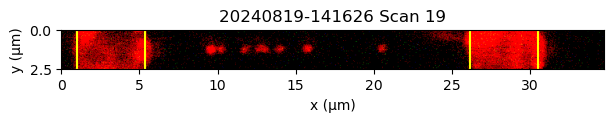

In [3]:
# Define the data folder path and dates to process
data_folder = '../test_folder/'
scan_name = '20240819-141626 Scan 19.h5'
# Process the kymographs to detect beads
process_scan_h5(data_folder, scan_name, bead_size=4.35)